# Mahalanobis - Softmax - Trusted for 20Newsgroup Datasets

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!pip install git+https://github.com/Julien2048/NLP_Project_OOD.git --quiet
!git clone https://github.com/Julien2048/NLP_Project_OOD
!pip install -r NLP_Project_OOD/requirements.txt --quiet

In [ ]:

%cd gdrive/MyDrive/NLP_Project_OOD/distilbert
!rm /usr/local/lib/python3.9/dist-packages/transformers/models/distilbert/modeling_distilbert.py
!cp modeling_distilbert.py /usr/local/lib/python3.9/dist-packages/transformers/models/distilbert/

!rm /usr/local/lib/python3.9/dist-packages/transformers/models/distilbert/__init__.py
!cp __init__.py /usr/local/lib/python3.9/dist-packages/transformers/models/distilbert/
%cd ..

%cd transformers
!rm /usr/local/lib/python3.9/dist-packages/transformers/__init__.py
!cp __init__.py /usr/local/lib/python3.9/dist-packages/transformers/
%cd ../../..

In [5]:
from nlp_project.data_loader import NewsgroupDataset
from nlp_project.OOD_detector import Mahalanobis, MaxSoftmax, IRW, KLDivergence
from nlp_project.metrics import ResultsOOD
from nlp_project.BERT_adaptation import DistilBertClassifier

## Load Classifier

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [7]:
model_prelogits = DistilBertClassifier(
    device=device,
    prelogits=True,
    path_pretrained_model="/content/gdrive/MyDrive/NLP_Project_OOD/models_trained/model_newsgroup_distilbert/",
    num_labels=15,
    )
model_hidden_state = DistilBertClassifier(
    device=device,
    prelogits=False,
    path_pretrained_model="/content/gdrive/MyDrive/NLP_Project_OOD/models_trained/model_newsgroup_distilbert/",
    num_labels=15,
    )

In [12]:
newsgroup_in_prelogits_train, newsgroup_in_logits_train = model_prelogits.load_prelogit_logit("newsgroup_in", "train", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/newsgroup/")
newsgroup_in_prelogits_test, newsgroup_in_logits_test = model_prelogits.load_prelogit_logit("newsgroup_in", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/newsgroup/")

newsgroup_out_prelogits_test, newsgroup_out_logits_test = model_prelogits.load_prelogit_logit("newsgroup_out", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/newsgroup/")

In [ ]:
newsgroup_in_hidden_state_train = model_hidden_state.load_hidden_layer("newsgroup_in", "train", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/newsgroup/")
newsgroup_in_hidden_state_test = model_hidden_state.load_hidden_layer("newsgroup_in", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/newsgroup/")

newsgroup_out_hidden_state_test = model_hidden_state.load_hidden_layer("newsgroup_out", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/newsgroup/")

## Computing OOD

### Logits

#### Maximum Softmax

In [ ]:
softmax = MaxSoftmax(
    newsgroup_in_logits_test,
    newsgroup_out_logits_test,
)
onehots_softmax, scores_softmax = softmax()
results_softmax = ResultsOOD(onehots_softmax, scores_softmax, add_to_title="Maximum Softmax: 20Newsgroup", plot_several=True)
results_softmax()
softmax_auroc, softmax_aupr, softmax_frp = results_softmax.auroc, results_softmax.aupr, results_softmax.fpr

#### KL Divergence

In [ ]:
kl = KLDivergence(
    newsgroup_in_logits_test,
    newsgroup_out_logits_test,
)
onehots_kl, scores_kl = kl()
results_kl = ResultsOOD(onehots_kl, scores_kl, add_to_title="KL Divergence: 20Newsgroup", plot_several=True)
results_kl()
kl_auroc, kl_aupr, kl_frp = results_kl.auroc, results_kl.aupr, results_kl.fpr

### PreLogits

#### Mahalanobis Score

In [ ]:
get_newsgroup = NewsgroupDataset()
newsgroup_in_train_labels, newsgroup_in_test_labels, newsgroup_out_test_labels = get_newsgroup.load_labels("/content/gdrive/MyDrive/NLP_Project_OOD/data/newsgroup/")

maha = Mahalanobis(
    newsgroup_in_prelogits_train,
    newsgroup_in_prelogits_test,
    newsgroup_out_prelogits_test,
    newsgroup_in_train_labels,
    substract_mean = False,
    normalize_to_unity = False,
    substract_train_distance = False,
    norm_name = "L1"
)
onehots_maha, scores_maha = maha()
results_maha = ResultsOOD(onehots_maha, scores_maha, add_to_title="Mahalanobis Score: 20Newsgroup", plot_several=True)
results_maha()
maha_auroc, maha_aupr, maha_frp = results_maha.auroc, results_maha.aupr, results_maha.fpr

### F_PM

#### IRW Score

In [ ]:
irw = IRW(
    in_train=newsgroup_in_hidden_state_train[:1000],
    in_test=newsgroup_in_hidden_state_test[:100],
    out_test=newsgroup_out_hidden_state_test[:100],
    n_dirs=768
)
onehots_irw, scores_irw = irw()
results_irw = ResultsOOD(onehots_irw, scores_irw, add_to_title="IRW Score: 20Newsgroup", plot_several=True)
results_irw()
irw_auroc, irw_aupr, irw_frp = results_irw.auroc, results_irw.aupr, results_irw.fpr

### Conclusion

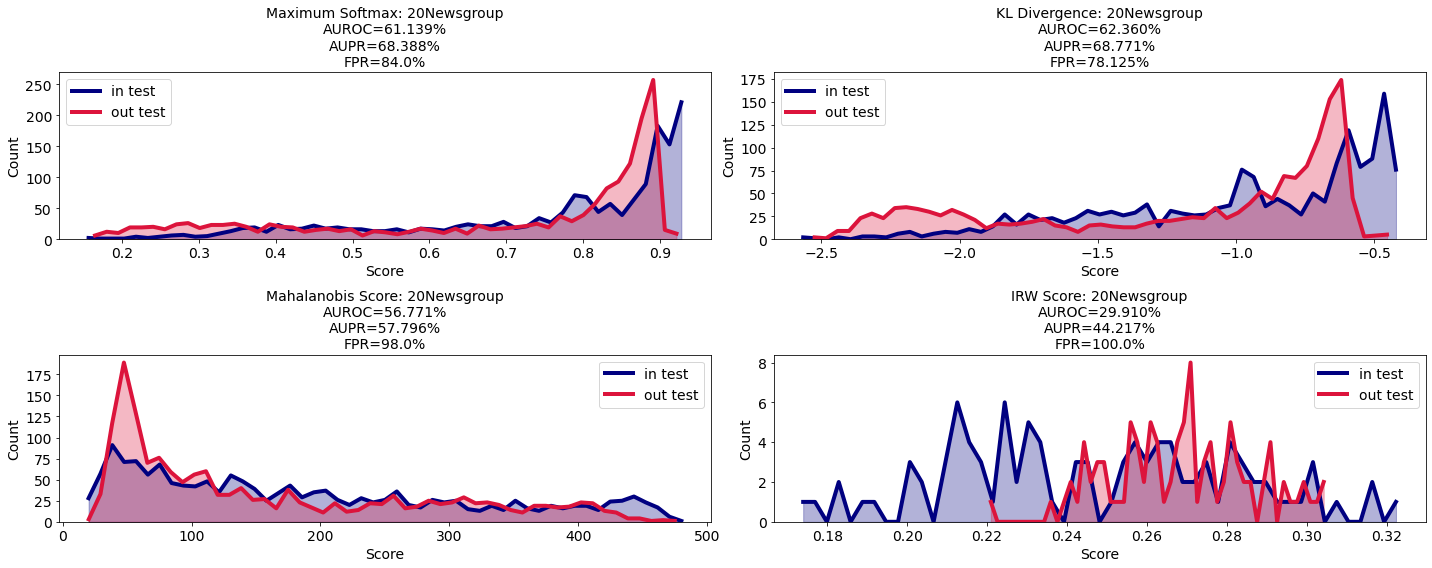

In [27]:
results = [results_softmax, results_kl, results_maha, results_irw]
plt.figure(figsize=(20, 8))

for result in results:
    plt.subplot(2, 2, results.index(result)+1)
    result()

### Summary Table

In [30]:
scores = ['MaxSoftmax', 'KL Divergence', 'Mahalanobis', 'IRW']
aggregation = ['Logits', 'Logits', 'Prelogits', 'F_PM']

auroc = [softmax_auroc, kl_auroc, maha_auroc, irw_auroc]
aupr = [softmax_aupr, kl_aupr, maha_aupr, irw_aupr]
fpr = [softmax_frp, kl_frp, maha_frp, irw_frp]

df = pd.DataFrame({'Datasets (out)':['20Newsgroup']*4, 'Scores':scores, 'Aggregation':aggregation, 'AUROC':auroc, 'AUPR':aupr, 'FPR':fpr})

def round_two_decimals(x):
    return "{:.1f}%".format(x * 100)

# apply the function to columns 'A' and 'B'
df[['AUROC', 'AUPR', 'FPR']] = df[['AUROC', 'AUPR', 'FPR']].applymap(round_two_decimals)
df = df.set_index(['Datasets (out)', 'Scores', 'Aggregation'])

In [31]:
df

AUROC   AUPR     FPR
Datasets (out) Scores        Aggregation                      
20Newsgroup    MaxSoftmax    Logits       61.1%  68.4%   84.0%
               KL Divergence Logits       62.4%  68.8%   78.1%
               Mahalanobis   Prelogits    56.8%  57.8%   98.0%
               IRW           F_PM         29.9%  44.2%  100.0%